# Sales Forecasting
## Using Machine Learning to predict sales

Kaggle [Dataset](https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data?select=train.csv)

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pallet = sns.color_palette()
plt.style.use('fivethirtyeight')

In [66]:
df = pd.read_csv('train.csv')
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [67]:
df = df.groupby('date').sum('sales')
df.index = pd.to_datetime(df.index)
df = df.drop(['store','item'], axis=1)
df.head()

,sales
date,
2013-01-01,13696
2013-01-02,13678
2013-01-03,14488
2013-01-04,15677
2013-01-05,16237


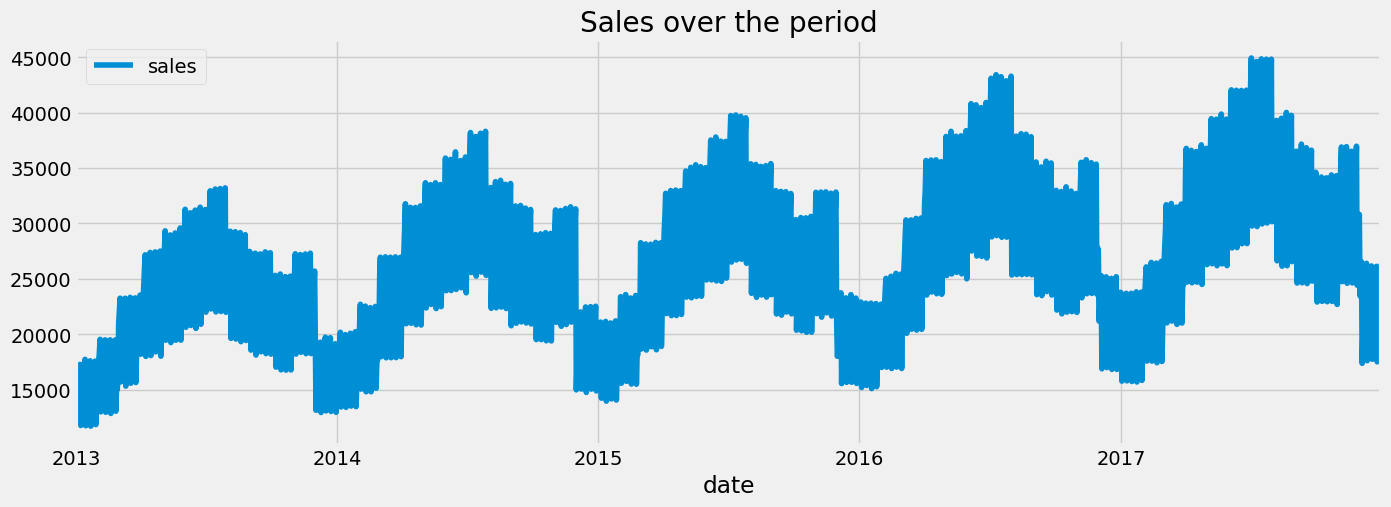

In [68]:
df.plot(
        # style='.',
        figsize=(15, 5),
        color=color_pallet[0],
        title='Sales over the period')
plt.show()

# Train and Test Split

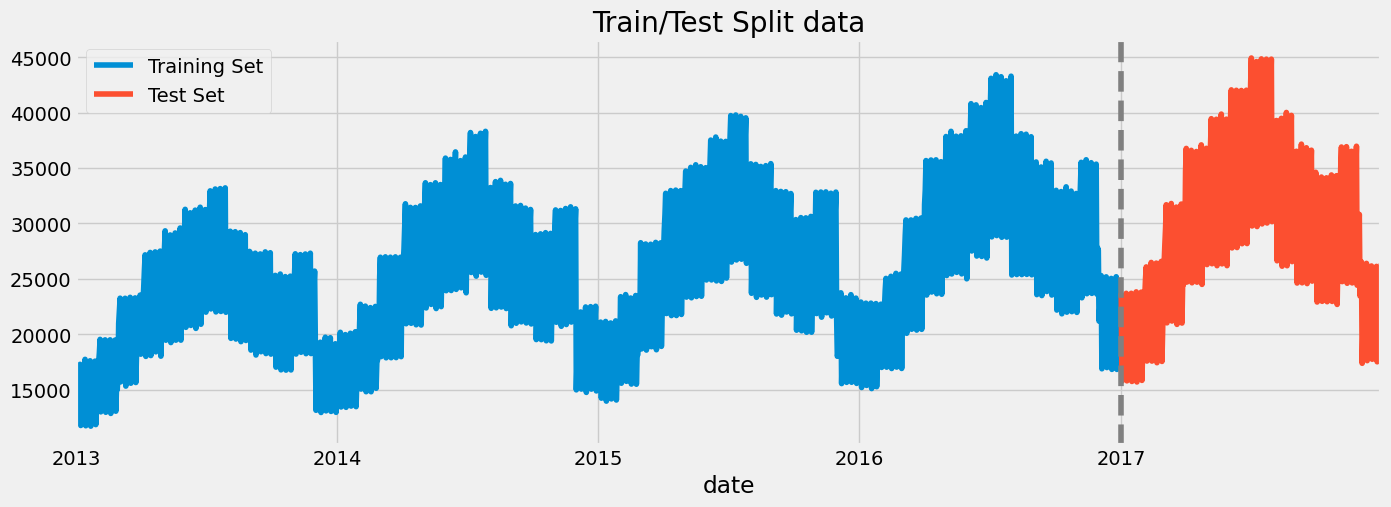

In [69]:
train = df.loc[df.index < '01-01-2017']
test = df.loc[df.index >= '01-01-2017']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Train/Test Split data')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2017', color='Gray', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

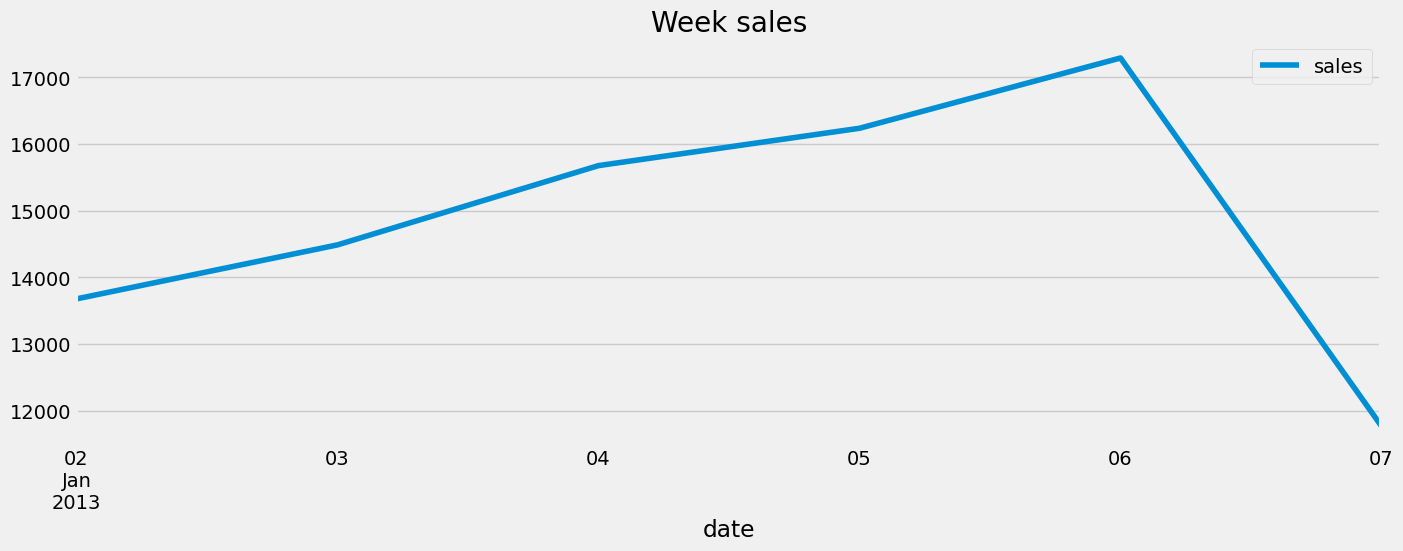

In [70]:
df.loc[(df.index > '01-01-2013') & (df.index < '01-08-2013')] \
    .plot(figsize=(15, 5), title='Week sales')
plt.show()

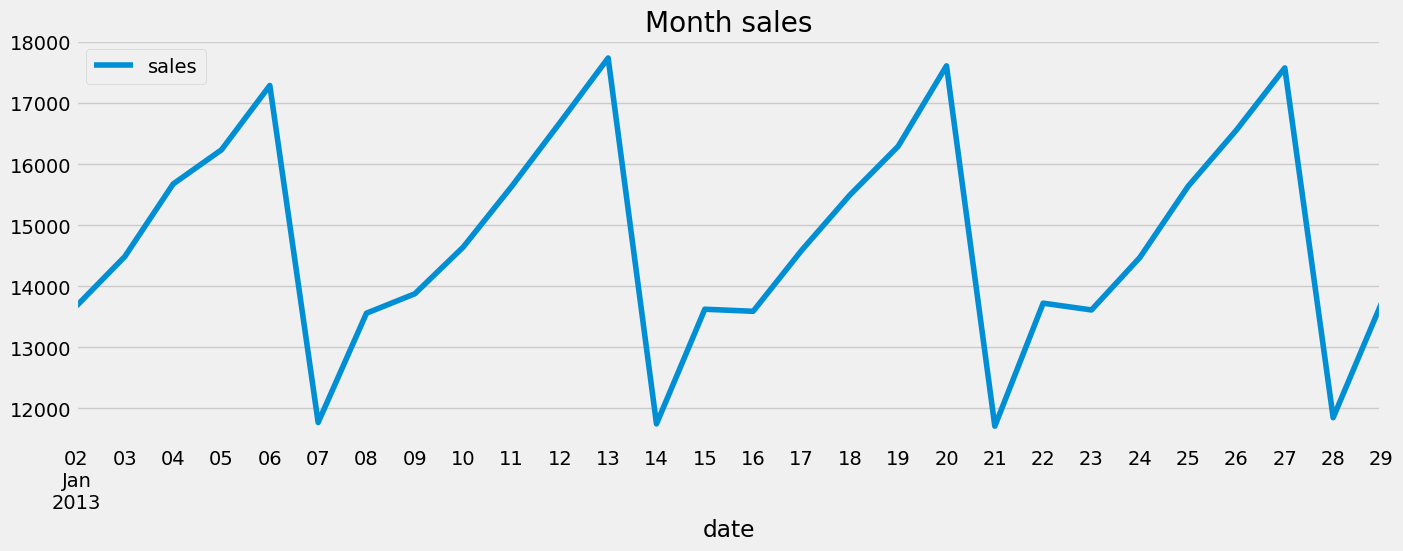

In [71]:
df.loc[(df.index > '01-01-2013') & (df.index < '01-30-2013')] \
    .plot(figsize=(15, 5), title='Month sales')
plt.show()

# Feature engineering

In [86]:
def create_features(df):
    """
    Creating time series features based on dataframe index.
    """
    df = df.copy()
    # df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)
print(df)

            sales  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
date                                                                        
2013-01-01  13696          1        1      1  2013          1           1   
2013-01-02  13678          2        1      1  2013          2           2   
2013-01-03  14488          3        1      1  2013          3           3   
2013-01-04  15677          4        1      1  2013          4           4   
2013-01-05  16237          5        1      1  2013          5           5   
...           ...        ...      ...    ...   ...        ...         ...   
2017-12-27  20378          2        4     12  2017        361          27   
2017-12-28  21885          3        4     12  2017        362          28   
2017-12-29  23535          4        4     12  2017        363          29   
2017-12-30  24988          5        4     12  2017        364          30   
2017-12-31  26420          6        4     12  2017        365          31   

# Visualizing feature and target Relationship

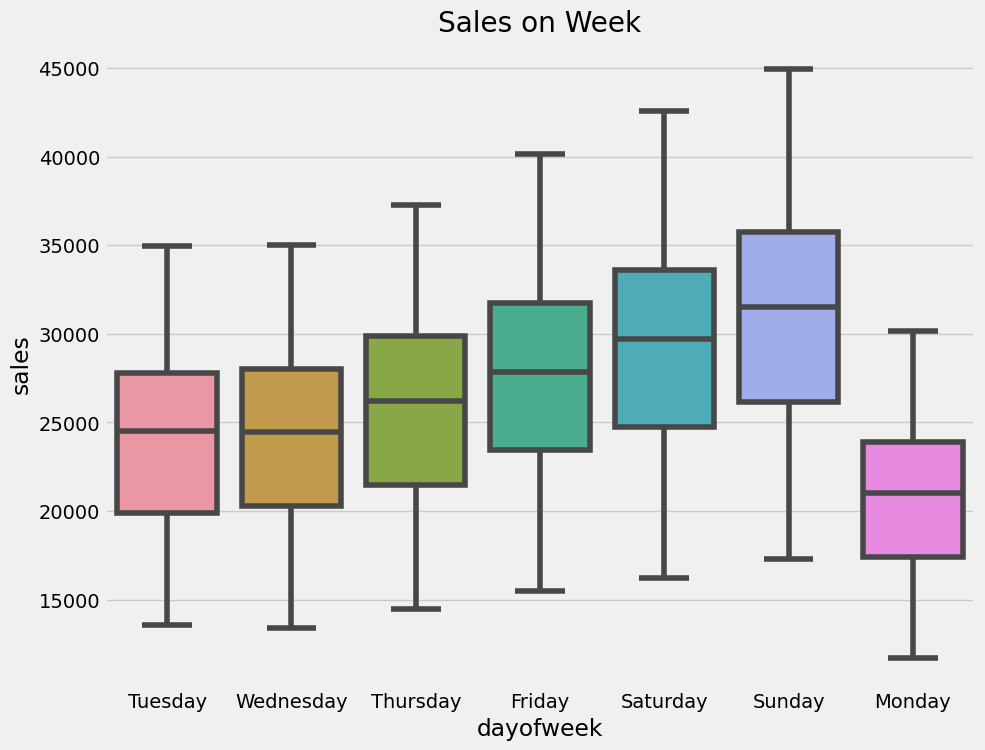

In [73]:
week_day_map = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday',
}
df_temp = df.copy()
df_temp['dayofweek'] = df_temp['dayofweek'].map(lambda index: week_day_map[index])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temp, x='dayofweek', y='sales')
ax.set_title('Sales on Week')
plt.show()

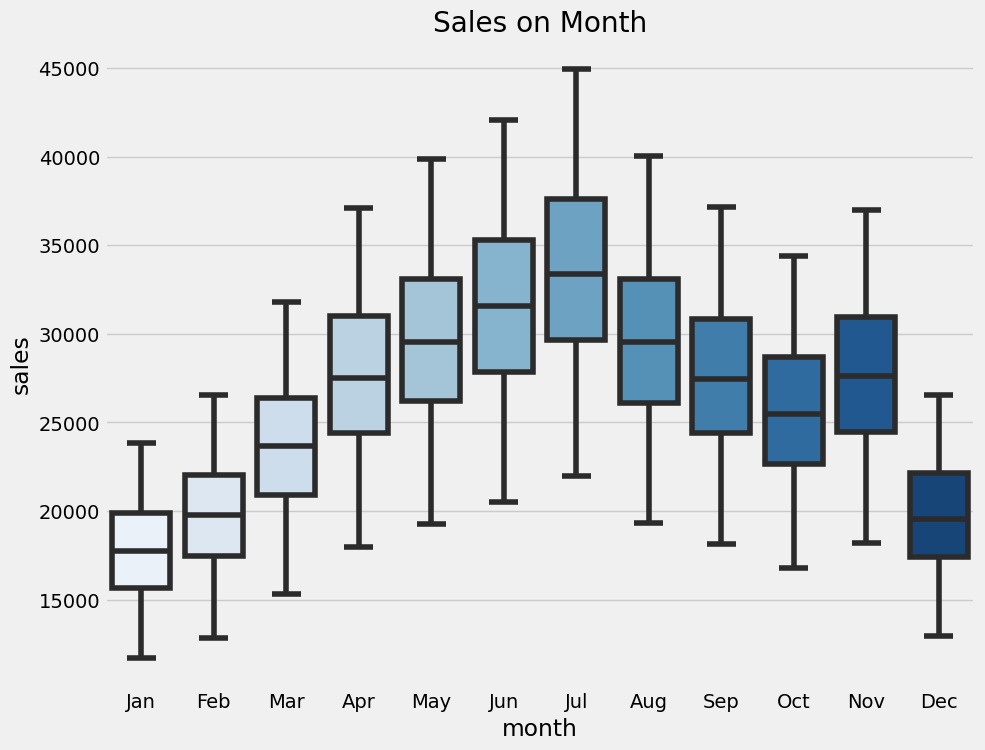

In [74]:
month_map = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
}
df_temp = df.copy()
df_temp['month'] = df_temp['month'].map(lambda index: month_map[index])

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temp, x='month', y='sales', palette='Blues')
ax.set_title('Sales on Month')
plt.show()

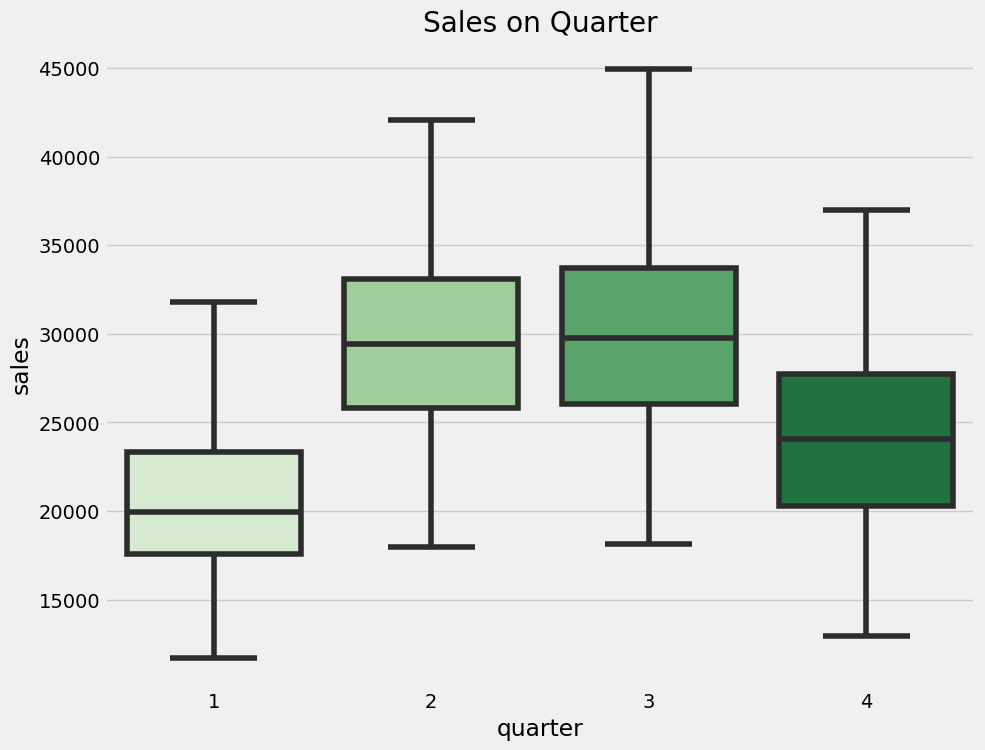

In [75]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_temp, x='quarter', y='sales', palette='Greens')
ax.set_title('Sales on Quarter')
plt.show()

# Creating Model

In [76]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'sales'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [77]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[13:39:54] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:25781.11056	validation_1-rmse:29862.55802
[100]	validation_0-rmse:9897.87720	validation_1-rmse:13274.18406
[200]	validation_0-rmse:4177.89475	validation_1-rmse:6517.88338
[300]	validation_0-rmse:2101.67242	validation_1-rmse:3841.10162
[400]	validation_0-rmse:1294.72473	validation_1-rmse:2647.11584
[500]	validation_0-rmse:907.44465	validation_1-rmse:2058.22142
[600]	validation_0-rmse:670.69706	validation_1-rmse:1742.36133
[700]	validation_0-rmse:483.59878	validation_1-rmse:1527.62284
[800]	validation_0-rmse:366.45311	validation_1-rmse:1401.71649
[900]	validation_0-rmse:298.34850	validation_1-rmse:1328.47304
[999]	validation_0-rmse:262.89210	validation_1-rmse:1283.85660


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

# Feature Importance

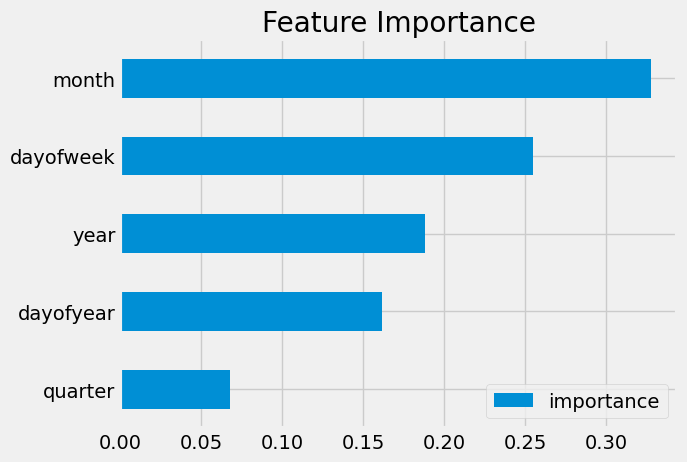

In [78]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

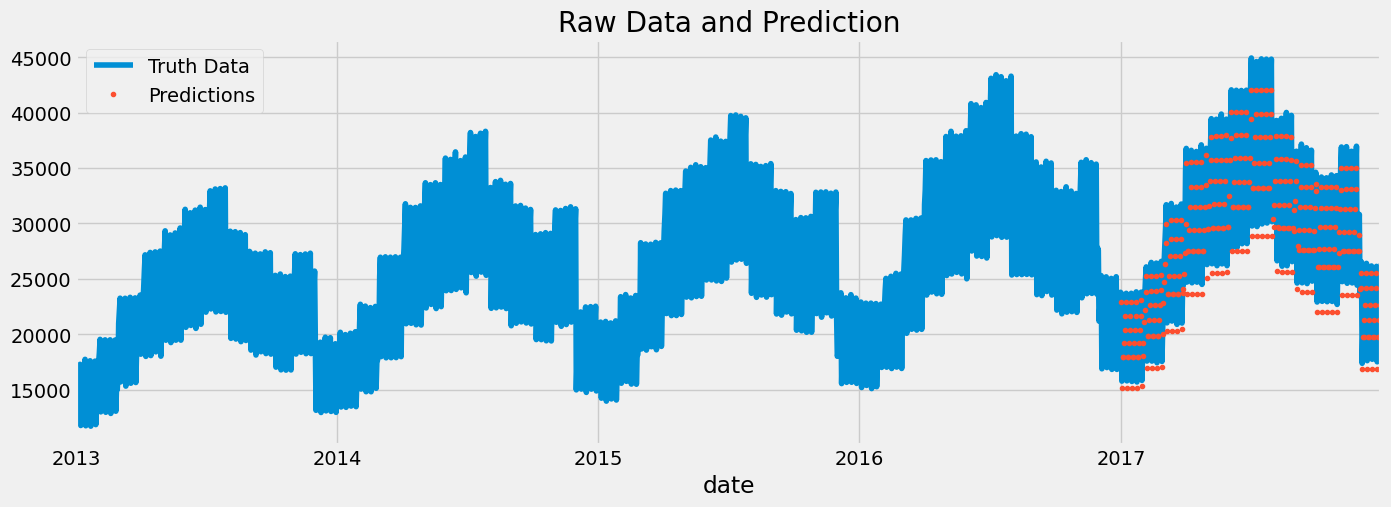

In [79]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

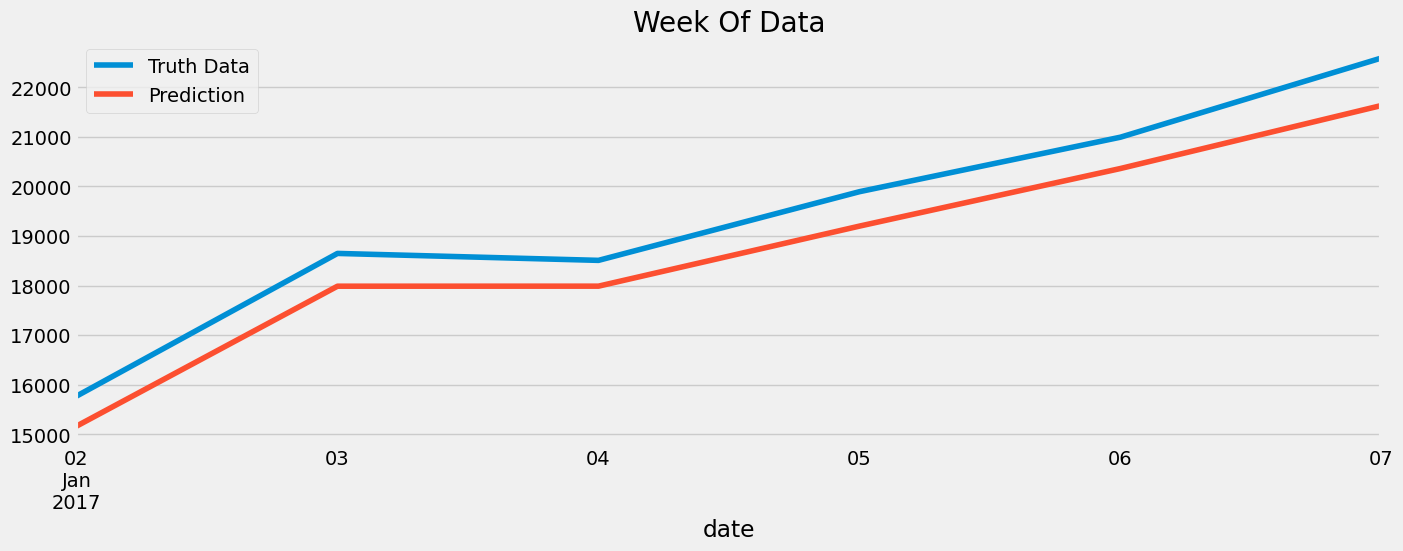

In [80]:
ax = df.loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')]['sales'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2017') & (df.index < '01-08-2017')]['prediction'] \
    .plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

# Score (RMSE)

In [81]:
score = np.sqrt(mean_squared_error(test['sales'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1283.86


# Calculate Error
- Look at the worst and best predicted days

In [82]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['dates'] = test.index.date

In [83]:
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2017-04-01    4793.648438
2017-07-01    3131.398438
2017-07-02    2920.183594
2017-07-16    2840.183594
2017-07-30    2816.183594
2017-07-23    2815.183594
2017-07-22    2626.316406
2017-07-09    2594.183594
2017-06-01    2418.449219
2017-07-15    2283.316406
Name: error, dtype: float64

## Lets predict on future

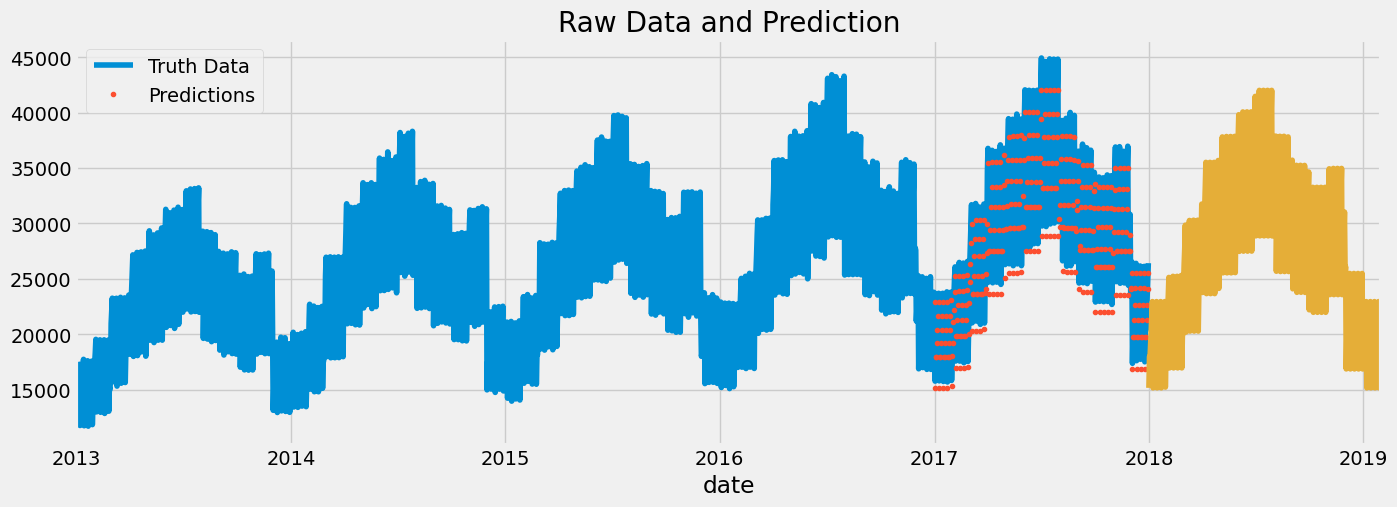

In [84]:
to_predict = pd.DataFrame(pd.date_range(start="2018-01-01", end="2019-02-01"), columns=['date'])
to_predict.index = pd.to_datetime(to_predict.date)

to_predict_feature = create_features(to_predict)
to_predict_feature = to_predict_feature[FEATURES]

to_predict_feature['prediction'] = reg.predict(to_predict_feature)
ax = df[['sales']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
to_predict_feature['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

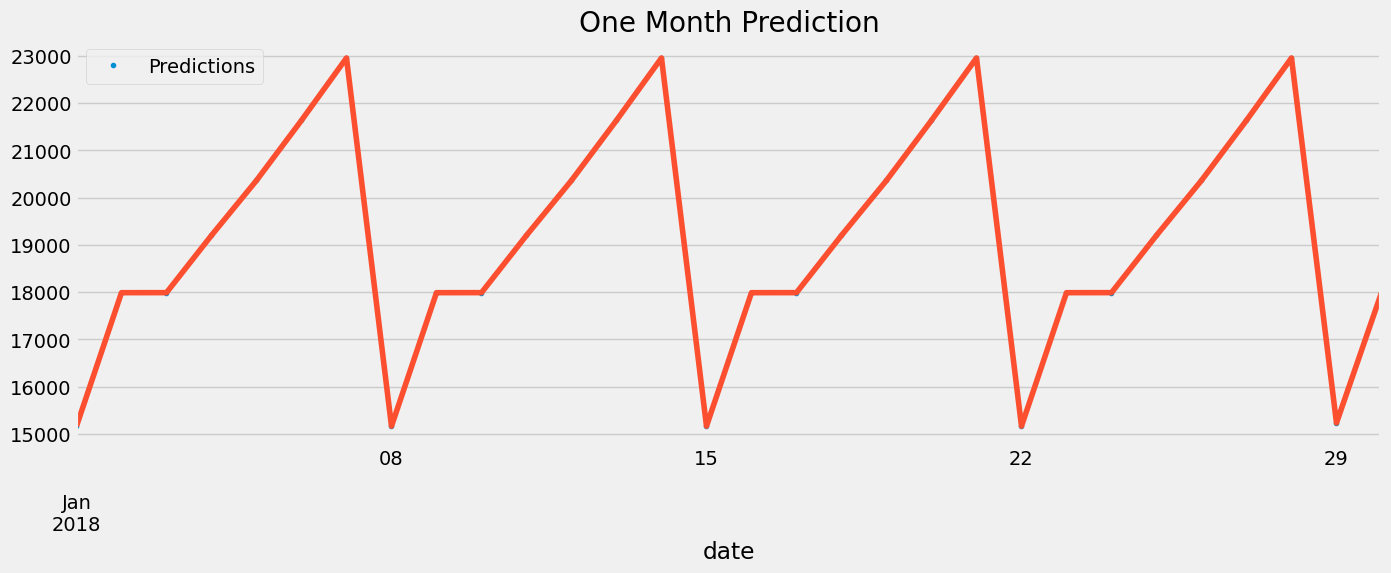

In [85]:
to_predict = pd.DataFrame(pd.date_range(start="2018-01-01", end="2018-01-30"), columns=['date'])
to_predict.index = pd.to_datetime(to_predict.date)

to_predict_feature = create_features(to_predict)
to_predict_feature = to_predict_feature[FEATURES]

to_predict_feature['prediction'] = reg.predict(to_predict_feature)
ax = to_predict_feature['prediction'].plot(figsize=(15, 5), style='.')
to_predict_feature['prediction'].plot(ax=ax)
plt.legend(['Predictions'])
ax.set_title('One Month Prediction')
plt.show()

# Next Steps
- More robust cross validation
- Get data from different sources and add more features (weather forecast, holidays)

# The End